[На основе туториалов билтиотеки sk-uplift](https://github.com/maks-sh/scikit-uplift/blob/master/notebooks/uplift_model_selection_tutorial.ipynb)

# Семинар 5. Uplift и PU



## 1. Lenta Uplift Modeling Dataset

Lenta is a russian food retailer.

Lenta dataset for uplift modeling contains data about Lenta's customers grociery shopping and related marketing campaigns.

The dataset was originally released for the [BIGTARGET Hackathon by LENTA and Microsoft](https://bigtarget.online/) and is accessible from `sklift.datasets` module using `fetch_lenta` function.

Read more about dataset <a href="https://www.uplift-modeling.com/en/latest/api/datasets/fetch_lenta.html">in the api docs</a>.

In [1]:
import sys

!{sys.executable} -m pip install scikit-uplift catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 829.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.8 MB/s eta 0:00:00


In [2]:
from sklift.datasets import fetch_lenta
from sklift.models import ClassTransformation
from sklift.metrics import uplift_at_k
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

%matplotlib inline

In [3]:
dataset = fetch_lenta()

print(f"Dataset type: {type(dataset)}\n")
print(f"Dataset features shape: {dataset.data.shape}")
print(f"Dataset target shape: {dataset.target.shape}")
print(f"Dataset treatment shape: {dataset.treatment.shape}")

dataset.keys()

Lenta dataset:   0%|          | 0.00/145M [00:00<?, ?iB/s]

Dataset type: <class 'sklearn.utils._bunch.Bunch'>

Dataset features shape: (687029, 193)
Dataset target shape: (687029,)
Dataset treatment shape: (687029,)


dict_keys(['data', 'target', 'treatment', 'DESCR', 'feature_names', 'target_name', 'treatment_name'])

Dataset is a dictionary-like object with the following attributes:
* ``data`` (DataFrame object): Dataset without target and treatment.
* ``target`` (Series object): Column target by values.
* ``treatment`` (Series object): Column treatment by values.
* ``DESCR`` (str): Description of the Lenta dataset.
* ``feature_names`` (list): Names of the features.
* ``target_name`` (str): Name of the target.
* ``treatment_name`` (str): Name of the treatment.
                
**Major columns:**
- treatment `group` (str): test/control group flag
- target `response_att` (binary): target
- data `gender` (str): customer gender
- data `age` (float): customer age
- data `main_format` (int): store type (1 - grociery store, 0 - superstore)

Detailed feature description could be found [here](https://www.uplift-modeling.com/en/latest/api/datasets/fetch_lenta.html#lenta).

### Target share for `treatment / control`

<Axes: xlabel='response_att', ylabel='count'>

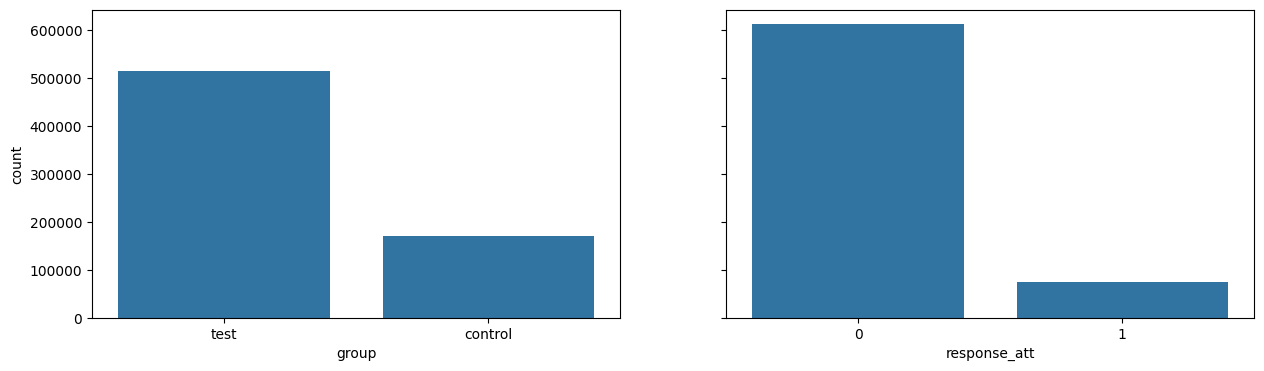

In [4]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,4))

treatment = dataset["treatment"]
target = dataset["target"]

sns.countplot(x=treatment, ax=ax[0])
sns.countplot(x=target, ax=ax[1])

The current sample is unbalanced in terms of both treatment and target.

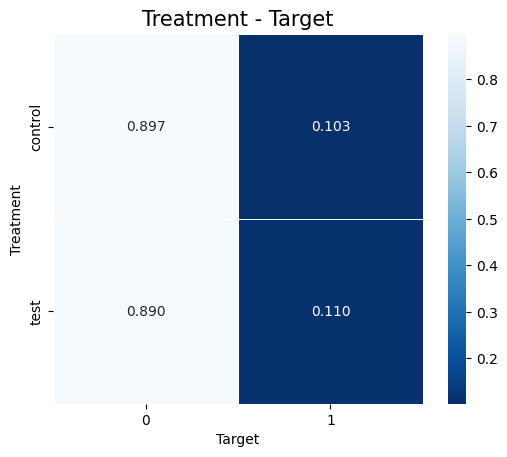

In [5]:
def crosstab_plot(treatment, target):
    ct = pd.crosstab(treatment, target, normalize='index')

    sns.heatmap(ct, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
    plt.ylabel('Treatment')
    plt.xlabel('Target')
    plt.title("Treatment - Target", size = 15)

crosstab_plot(dataset.treatment, dataset.target)

### Distributions of some features by treatment

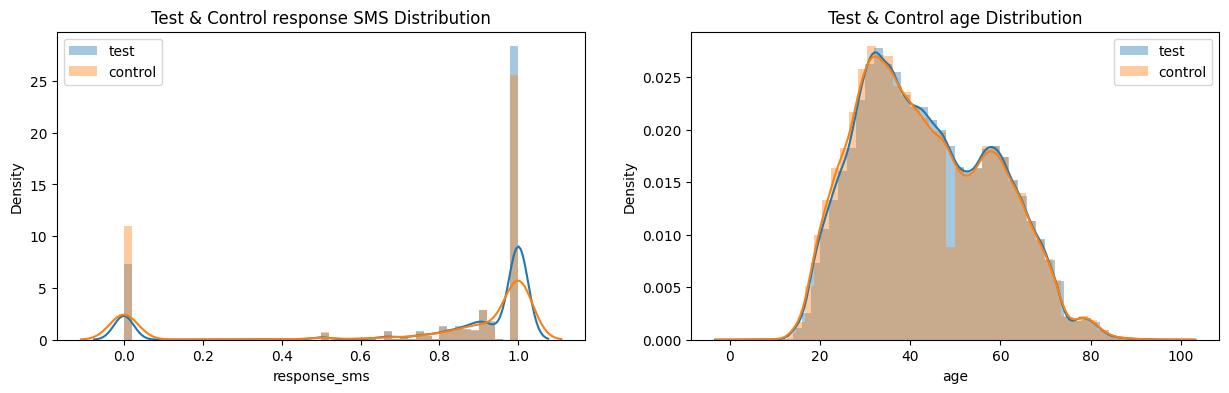

In [6]:
fig, ax = plt.subplots(1,2, figsize=(15,4))

test_index = dataset.treatment[dataset.treatment == 'test'].index
control_index = dataset.treatment[dataset.treatment == 'control'].index

sns.distplot(dataset.data.loc[test_index, 'response_sms'], label='test', ax=ax[0])
sns.distplot(dataset.data.loc[control_index, 'response_sms'], label='control', ax=ax[0])
ax[0].title.set_text('Test & Control response SMS Distribution')
ax[0].legend()

sns.distplot(dataset.data.loc[test_index, 'age'], label='test', ax=ax[1])
sns.distplot(dataset.data.loc[control_index, 'age'], label='control', ax=ax[1])
ax[1].title.set_text('Test & Control age Distribution')
ax[1].legend()

Clients from the test treatment group tend to respond to sms with a slightly greater probability than clients from the control group. The behavior in the test and control groups does not differ depending on the clients age.

### Data analysys

In [7]:
dataset.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687029 entries, 0 to 687028
Columns: 193 entries, age to stdev_discount_depth_1m
dtypes: float64(191), int64(1), object(1)
memory usage: 1011.6+ MB


In [8]:
dataset.data.head().append(dataset.data.tail())

,age,cheque_count_12m_g20,cheque_count_12m_g21,cheque_count_12m_g25,cheque_count_12m_g32,cheque_count_12m_g33,cheque_count_12m_g38,cheque_count_12m_g39,cheque_count_12m_g41,cheque_count_12m_g42,cheque_count_12m_g45,cheque_count_12m_g46,cheque_count_12m_g48,cheque_count_12m_g52,cheque_count_12m_g56,cheque_count_12m_g57,cheque_count_12m_g58,cheque_count_12m_g79,cheque_count_3m_g20,cheque_count_3m_g21,cheque_count_3m_g25,cheque_count_3m_g42,cheque_count_3m_g45,cheque_count_3m_g52,cheque_count_3m_g56,cheque_count_3m_g57,cheque_count_3m_g79,cheque_count_6m_g20,cheque_count_6m_g21,cheque_count_6m_g25,cheque_count_6m_g32,cheque_count_6m_g33,cheque_count_6m_g38,cheque_count_6m_g39,cheque_count_6m_g40,cheque_count_6m_g41,cheque_count_6m_g42,cheque_count_6m_g45,cheque_count_6m_g46,cheque_count_6m_g48,cheque_count_6m_g52,cheque_count_6m_g56,cheque_count_6m_g57,cheque_count_6m_g58,cheque_count_6m_g79,children,crazy_purchases_cheque_count_12m,crazy_purchases_cheque_count_1m,crazy_purchases_cheque_count_3m,crazy_purchases_cheque_count_6m,crazy_purchases_goods_count_12m,crazy_purchases_goods_count_6m,disc_sum_6m_g34,food_share_15d,food_share_1m,gender,k_var_cheque_15d,k_var_cheque_3m,k_var_cheque_category_width_15d,k_var_cheque_group_width_15d,k_var_count_per_cheque_15d_g24,k_var_count_per_cheque_15d_g34,k_var_count_per_cheque_1m_g24,k_var_count_per_cheque_1m_g27,k_var_count_per_cheque_1m_g34,k_var_count_per_cheque_1m_g44,k_var_count_per_cheque_1m_g49,k_var_count_per_cheque_3m_g24,k_var_count_per_cheque_3m_g27,k_var_count_per_cheque_3m_g32,k_var_count_per_cheque_3m_g34,k_var_count_per_cheque_3m_g41,k_var_count_per_cheque_3m_g44,k_var_count_per_cheque_6m_g24,k_var_count_per_cheque_6m_g27,k_var_count_per_cheque_6m_g32,k_var_count_per_cheque_6m_g44,k_var_days_between_visits_15d,k_var_days_between_visits_1m,k_var_days_between_visits_3m,k_var_disc_per_cheque_15d,k_var_disc_share_12m_g32,k_var_disc_share_15d_g24,k_var_disc_share_15d_g34,k_var_disc_share_15d_g49,k_var_disc_share_1m_g24,k_var_disc_share_1m_g27,k_var_disc_share_1m_g34,k_var_disc_share_1m_g40,k_var_disc_share_1m_g44,k_var_disc_share_1m_g49,k_var_disc_share_1m_g54,k_var_disc_share_3m_g24,k_var_disc_share_3m_g26,k_var_disc_share_3m_g27,k_var_disc_share_3m_g32,k_var_disc_share_3m_g33,k_var_disc_share_3m_g34,k_var_disc_share_3m_g38,k_var_disc_share_3m_g40,k_var_disc_share_3m_g41,k_var_disc_share_3m_g44,k_var_disc_share_3m_g46,k_var_disc_share_3m_g48,k_var_disc_share_3m_g49,k_var_disc_share_3m_g54,k_var_disc_share_6m_g24,k_var_disc_share_6m_g27,k_var_disc_share_6m_g32,k_var_disc_share_6m_g34,k_var_disc_share_6m_g44,k_var_disc_share_6m_g46,k_var_disc_share_6m_g49,k_var_disc_share_6m_g54,k_var_discount_depth_15d,k_var_discount_depth_1m,k_var_sku_per_cheque_15d,k_var_sku_price_12m_g32,k_var_sku_price_15d_g34,k_var_sku_price_15d_g49,k_var_sku_price_1m_g24,k_var_sku_price_1m_g26,k_var_sku_price_1m_g27,k_var_sku_price_1m_g34,k_var_sku_price_1m_g40,k_var_sku_price_1m_g44,k_var_sku_price_1m_g49,k_var_sku_price_1m_g54,k_var_sku_price_3m_g24,k_var_sku_price_3m_g26,k_var_sku_price_3m_g27,k_var_sku_price_3m_g32,k_var_sku_price_3m_g33,k_var_sku_price_3m_g34,k_var_sku_price_3m_g40,k_var_sku_price_3m_g41,k_var_sku_price_3m_g44,k_var_sku_price_3m_g46,k_var_sku_price_3m_g48,k_var_sku_price_3m_g49,k_var_sku_price_3m_g54,k_var_sku_price_6m_g24,k_var_sku_price_6m_g26,k_var_sku_price_6m_g27,k_var_sku_price_6m_g32,k_var_sku_price_6m_g41,k_var_sku_price_6m_g42,k_var_sku_price_6m_g44,k_var_sku_price_6m_g48,k_var_sku_price_6m_g49,main_format,mean_discount_depth_15d,months_from_register,perdelta_days_between_visits_15_30d,promo_share_15d,response_sms,response_viber,sale_count_12m_g32,sale_count_12m_g33,sale_count_12m_g49,sale_count_12m_g54,sale_count_12m_g57,sale_count_3m_g24,sale_count_3m_g33,sale_count_3m_g57,sale_count_6m_g24,sale_count_6m_g25,sale_count_6m_g32,sale_count_6m_g33,sale_count_6m_g44,sale_count_6m_g54,sale_count_6m_g57,sale_sum_12m_g24,sale_sum_12m_g25,sale_sum_12m_g26,sale_sum_12m_g27,sale_sum_12m_

* There are 193 columns in the dataset
* The dataset contains:
    - basic information about clients (age, number of children)
    - information about some groups of goods
    - statistical information (variation of discounts, prices)


### Missing values

In [9]:
# check NaN values ratio
pd.DataFrame({"Total" : dataset.data.isna().sum().sort_values(ascending = False),
              "Percentage" : round(dataset.data.isna().sum().sort_values(ascending = False) / len(dataset.data), 3)}).head(20)


,Total,Percentage
k_var_sku_price_15d_g49,496259,0.722
k_var_disc_share_15d_g49,496159,0.722
k_var_count_per_cheque_15d_g34,468551,0.682
k_var_sku_price_15d_g34,468551,0.682
k_var_disc_share_15d_g34,468467,0.682
k_var_count_per_cheque_15d_g24,442121,0.644
k_var_disc_share_15d_g24,442054,0.643
k_var_count_per_cheque_1m_g49,414473,0.603
k_var_sku_price_1m_g49,414473,0.603
k_var_disc_share_1m_g49,414369,0.603


In [10]:
print('Total missed data percentage:',
      round(100*dataset.data.isna().sum().sum()/(dataset.data.shape[0]*dataset.data.shape[1]), 2), '%')


Total missed data percentage: 19.34 %


### Data transformation

Transform categorical columns `gender` and `treatment` into binary.

In [11]:
# make treatment binary
treat_dict = {
    'test': 1,
    'control': 0
}
dataset.treatment = dataset.treatment.map(treat_dict)

# make gender binary
gender_dict = {
    'M': 1,
    'Ж': 0
}
dataset.data.gender = dataset.data.gender.map(gender_dict)


### Feature correlation

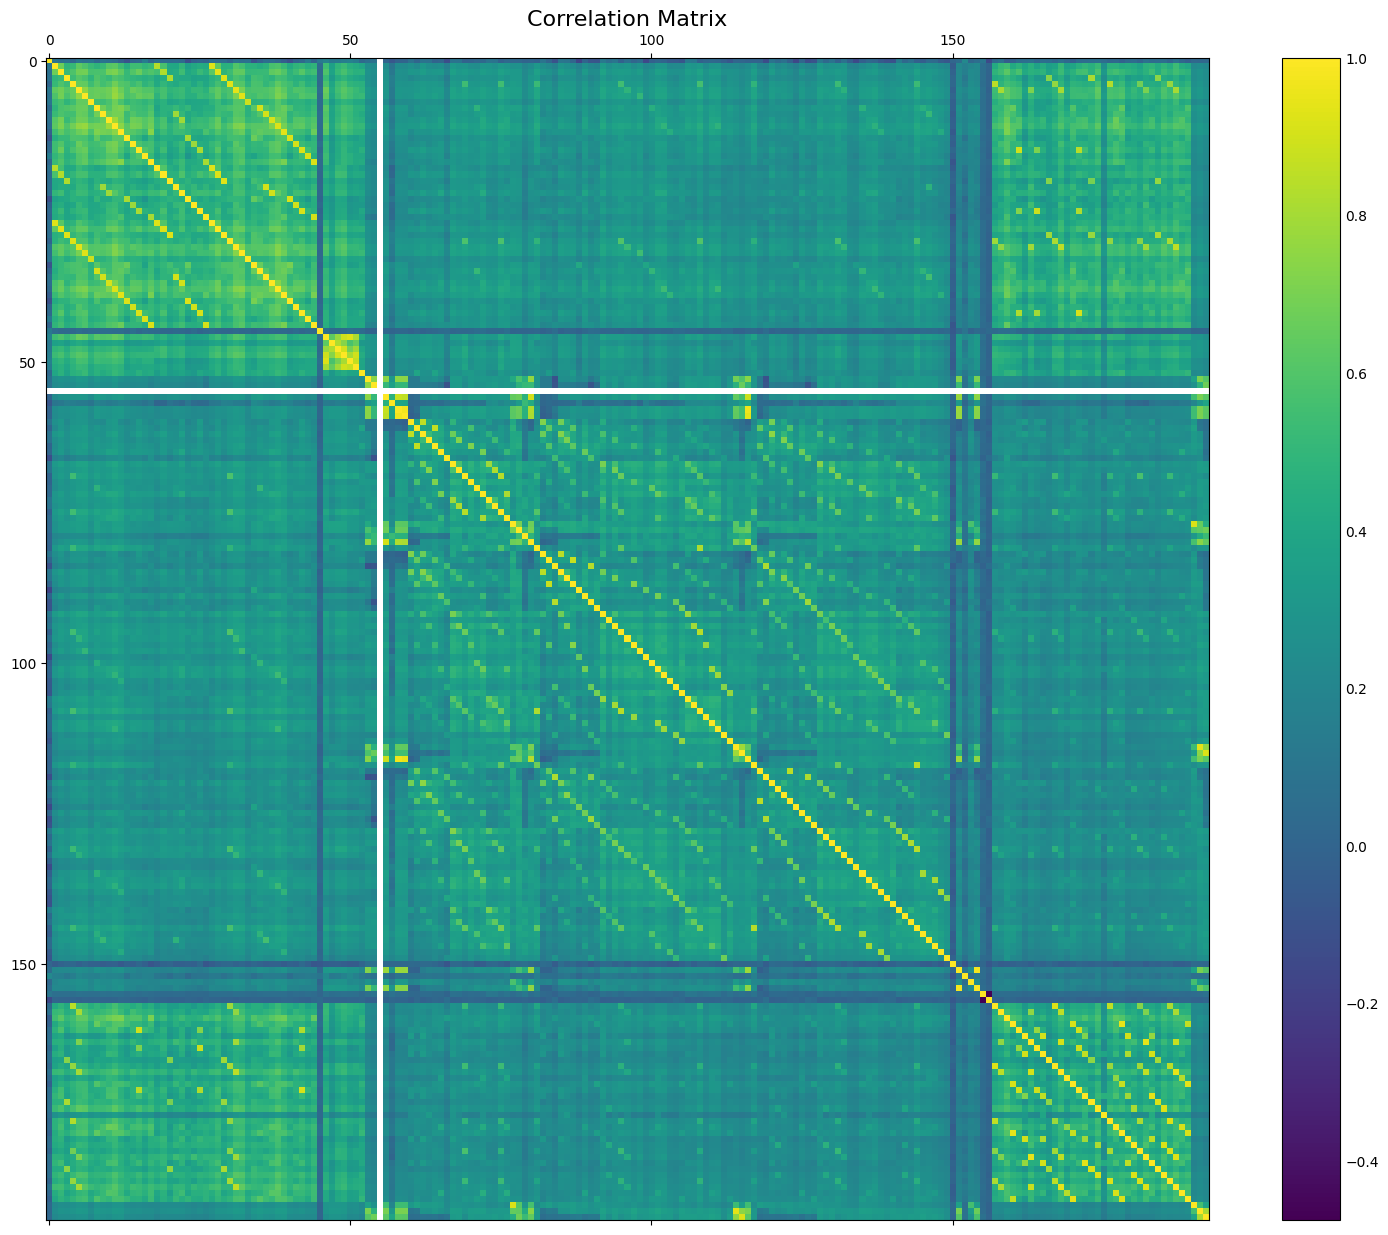

In [12]:
f = plt.figure(figsize=(19, 15))
plt.matshow(dataset.data.corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(axis=u'both', which=u'both',length=0)
plt.title('Correlation Matrix', fontsize=16);

### Train/test split

- stratify by two columns: treatment and target.

`Intuition:` In a binary classification problem definition we stratify train set by splitting target `0/1` column. In uplift modeling we have two columns instead of one.

In [13]:
stratify_cols = pd.concat([dataset.treatment, dataset.target], axis=1)

X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split(
    dataset.data,
    dataset.treatment,
    dataset.target,
    stratify=stratify_cols,
    test_size=0.3,
    random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

Train shape: (480920, 193)
Validation shape: (206109, 193)


### Pipeline with CatBoostClassifier

In [14]:
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
estimator = CatBoostClassifier(verbose=100,
                               random_state=42,
                               thread_count=1)
ct_model = ClassTransformation(estimator=estimator)

my_pipeline = Pipeline([
    ('imputer', imp_mode),
    ('model', ct_model)
])

Usual fit pipeline but with aditional treatment parameter
`model__treatment = trmnt_train`.
    

In [15]:
my_pipeline = my_pipeline.fit(
    X=X_train,
    y=y_train,
    model__treatment=trmnt_train
)

Learning rate set to 0.143939
0:	learn: 0.6692264	total: 455ms	remaining: 7m 34s
100:	learn: 0.5950484	total: 42s	remaining: 6m 13s
200:	learn: 0.5908476	total: 1m 21s	remaining: 5m 24s
300:	learn: 0.5871219	total: 2m 2s	remaining: 4m 44s
400:	learn: 0.5834411	total: 2m 43s	remaining: 4m 3s
500:	learn: 0.5801309	total: 3m 22s	remaining: 3m 22s
600:	learn: 0.5769242	total: 4m 3s	remaining: 2m 41s
700:	learn: 0.5736238	total: 4m 43s	remaining: 2m
800:	learn: 0.5705597	total: 5m 24s	remaining: 1m 20s
900:	learn: 0.5674382	total: 6m 7s	remaining: 40.4s
999:	learn: 0.5645905	total: 6m 47s	remaining: 0us


Predict uplift and calculate basic uplift metric **uplift@30%** at first 30%. Read more about the metric [in docs](https://www.uplift-modeling.com/en/latest/api/metrics/uplift_at_k.html).

In [16]:
uplift_predictions = my_pipeline.predict(X_val)

#uplift_30 = uplift_at_k(y_val, uplift_predictions, trmnt_val, strategy='overall')
uplift_30 = uplift_at_k(y_val, uplift_predictions, trmnt_val, strategy='by_group')
print(f'uplift@30%: {uplift_30:.4f}')

uplift@30%: 0.0314


In [17]:
models_results = {'approach' : [], 'uplift@30%' : []}
models_results['approach'].append('pipe')
models_results['uplift@30%'].append(uplift_30)

## 1. Подходы с одной моделью
### 1.1 Одна модель с признаком коммуникации
Самое простое и интуитивное решение: модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомы uplift. 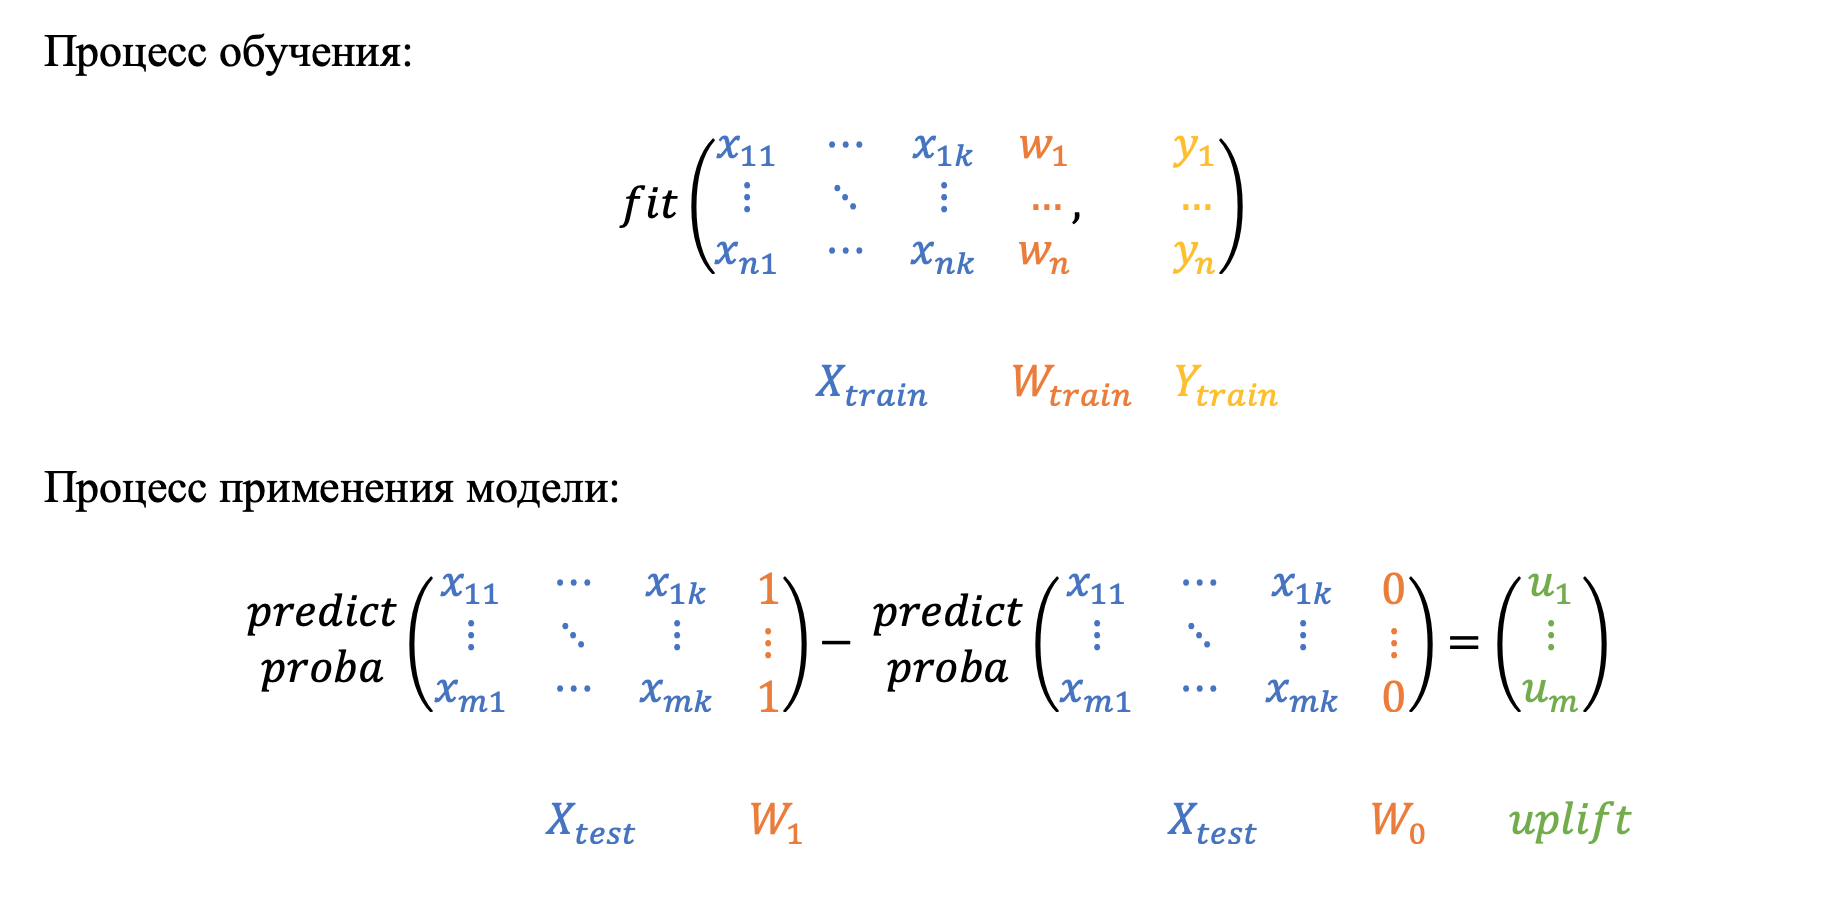

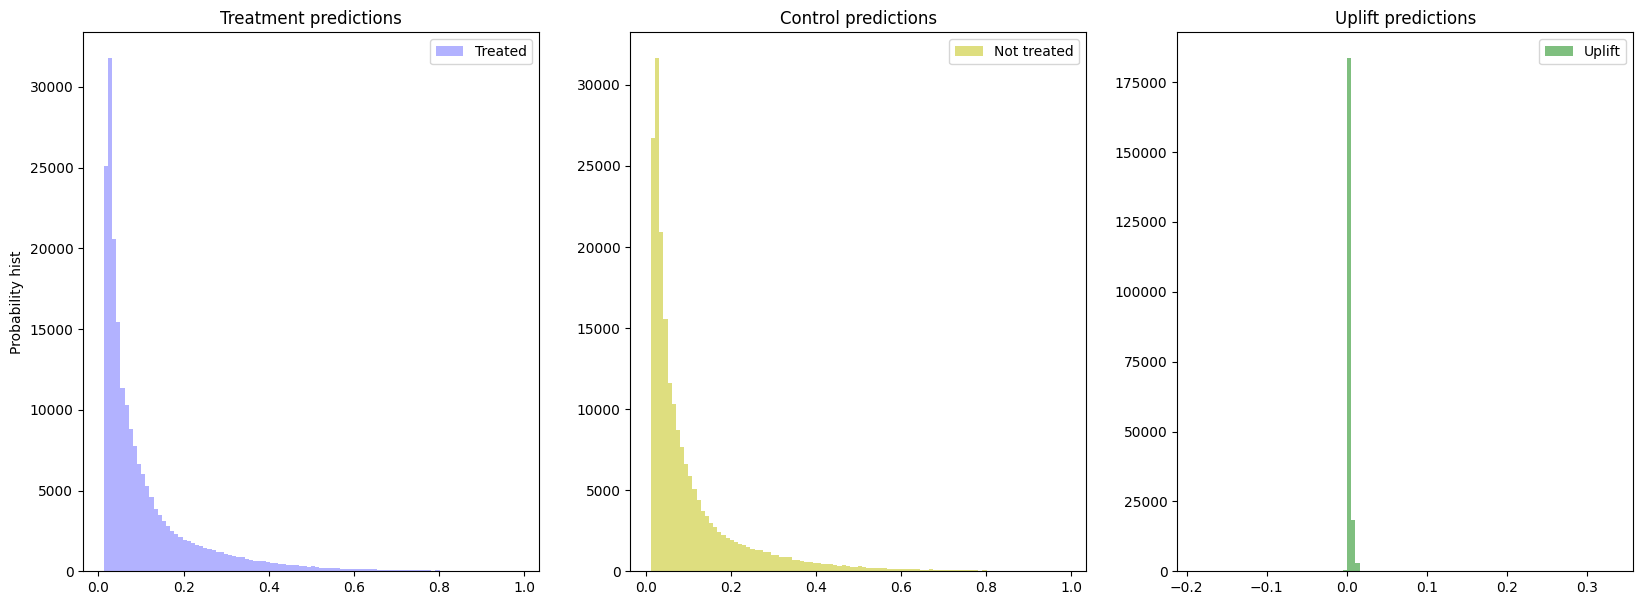

In [18]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm_pipeline = Pipeline([
    ('imputer', imp_mode),
    ('model', sm)
])

sm_pipeline = sm_pipeline.fit(
    X=X_train,
    y=y_train,
    model__treatment=trmnt_train
)


#sm = sm.fit(X_train, y_train, trmnt_train)
uplift_sm = sm_pipeline.predict(X_val)
sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=trmnt_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm_pipeline['model'].trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm_pipeline['model'].ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);


In [19]:
models_results

{'approach': ['pipe', 'SoloModel'],
 'uplift@30%': [0.03139659550634985, 0.011857502164057954]}

### 1.2 Трансформация классов

Достаточно интересный и математически подтвержденный подход к построению модели, представленный еще в 2012 году. Метод заключается в прогнозировании немного измененного таргета:

$$
Z_i = Y_i \cdot W_i + (1 - Y_i) \cdot (1 - W_i),
$$
где

* $Z_i$ - новая целевая переменная $i$-ого клиента;
* $Y_i$ - целевая перемнная $i$-ого клиента;
* $W_i$ - флаг коммуникации $i$-ого клиента;  


Другими словами, новый класс равен 1, если мы знаем, что на конкретном наблюдении, результат при взаимодействии был бы таким же хорошим, как и в контрольной группе, если бы мы могли знать результат в обеих группах:

$$
Z_i = \begin{cases}
    1, & \mbox{if } W_i = 1 \mbox{ and } Y_i = 1 \\
    1, & \mbox{if } W_i = 0 \mbox{ and } Y_i = 0 \\
    0, & \mbox{otherwise}
   \end{cases}
$$

Распишем подробнее, чему равна вероятность новой целевой переменной:

$$
P(Z=1|X = x) = \\
= P(Z=1|X = x, W = 1) \cdot P(W = 1|X = x) + \\
+ P(Z=1|X = x, W = 0) \cdot P(W = 0|X = x) = \\
= P(Y=1|X = x, W = 1) \cdot P(W = 1|X = x) + \\
+ P(Y=0|X = x, W = 0) \cdot P(W = 0|X = x).
$$

Выше мы обсуждали, что обучающая выборка для моделирования uplift собирается на основе рандомизированного разбиения части клиенской базы на тестовую и контрольную группы. Поэтому коммуникация $ W $ не может зависить от признаков клиента $ X_1, ..., X_m $. Принимая это, мы имеем: $ P(W | X_1, ..., X_m, ) = P(W) $ и

$$
P(Z=1|X = x) = \\
= P^T(Y=1|X = x) \cdot P(W = 1) + \\
+ P^C(Y=0|X = x) \cdot P(W = 0)
$$

Также допустим, что $P(W = 1) = P(W = 0) = \frac{1}{2}$, т.е. во время эксперимента контрольные и тестовые группы были разделены в равных пропорциях. Тогда получим следующее:

$$
P(Z=1|X = x) = \\
= P^T(Y=1|X = x) \cdot \frac{1}{2} + P^C(Y=0|X = x) \cdot \frac{1}{2} \Rightarrow \\
2 \cdot P(Z=1|X = x) = \\
= P^T(Y=1|X = x) + P^C(Y=0|X = x) = \\
= P^T(Y=1|X = x) + 1 - P^C(Y=1|X = x) \Rightarrow \\
\Rightarrow P^T(Y=1|X = x) - P^C(Y=1|X = x) = \\
 = uplift = 2 \cdot P(Z=1|X = x) - 1
$$

Таким образом, увеличив вдвое прогноз нового таргета и вычтя из него единицу мы получим значение самого uplift'a, т.е.

$$
uplift = 2 \cdot P(Z=1) - 1
$$

Исходя из допущения описанного выше: $P(W = 1) = P(W = 0) = \frac{1}{2}$, данный подход следует использовать только в случаях, когда количество клиентов, с которыми мы прокоммуницировлаи, равно количеству клиентов, с которыми коммуникации не было.

In [20]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, trmnt_train)

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=trmnt_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

In [21]:
models_results

{'approach': ['pipe', 'SoloModel', 'ClassTransformation'],
 'uplift@30%': [0.03139659550634985,
  0.011857502164057954,
  0.03161840043430228]}

## 1.2. Подходы с двумя моделями
Подход с двумя моделями можно встретить почти в любой работе по uplift моделированию, он часто используется в качестве бейзлайна. Однако использование двух моделей может привести к некоторым неприятным последствиям: если для обучения будут использоваться принципиально разные модели или природа данных тестовой и контрольной групп будут сильно отличаться, то возвращаемые моделями скоры будут не сопоставимы между собой. Вследствие чего расчет uplift будет не совсем корректным. Для избежания такого эффекта необходимо калибровать модели, чтобы их скоры можно было интерпертировать как вероятности. Калибровка вероятностей модели отлично описана в документации scikit-learn.

### 1.2.1 Две независимые модели
Как понятно из названия, подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно. В статьях утверждается, что такой подход достаточно слабый, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.

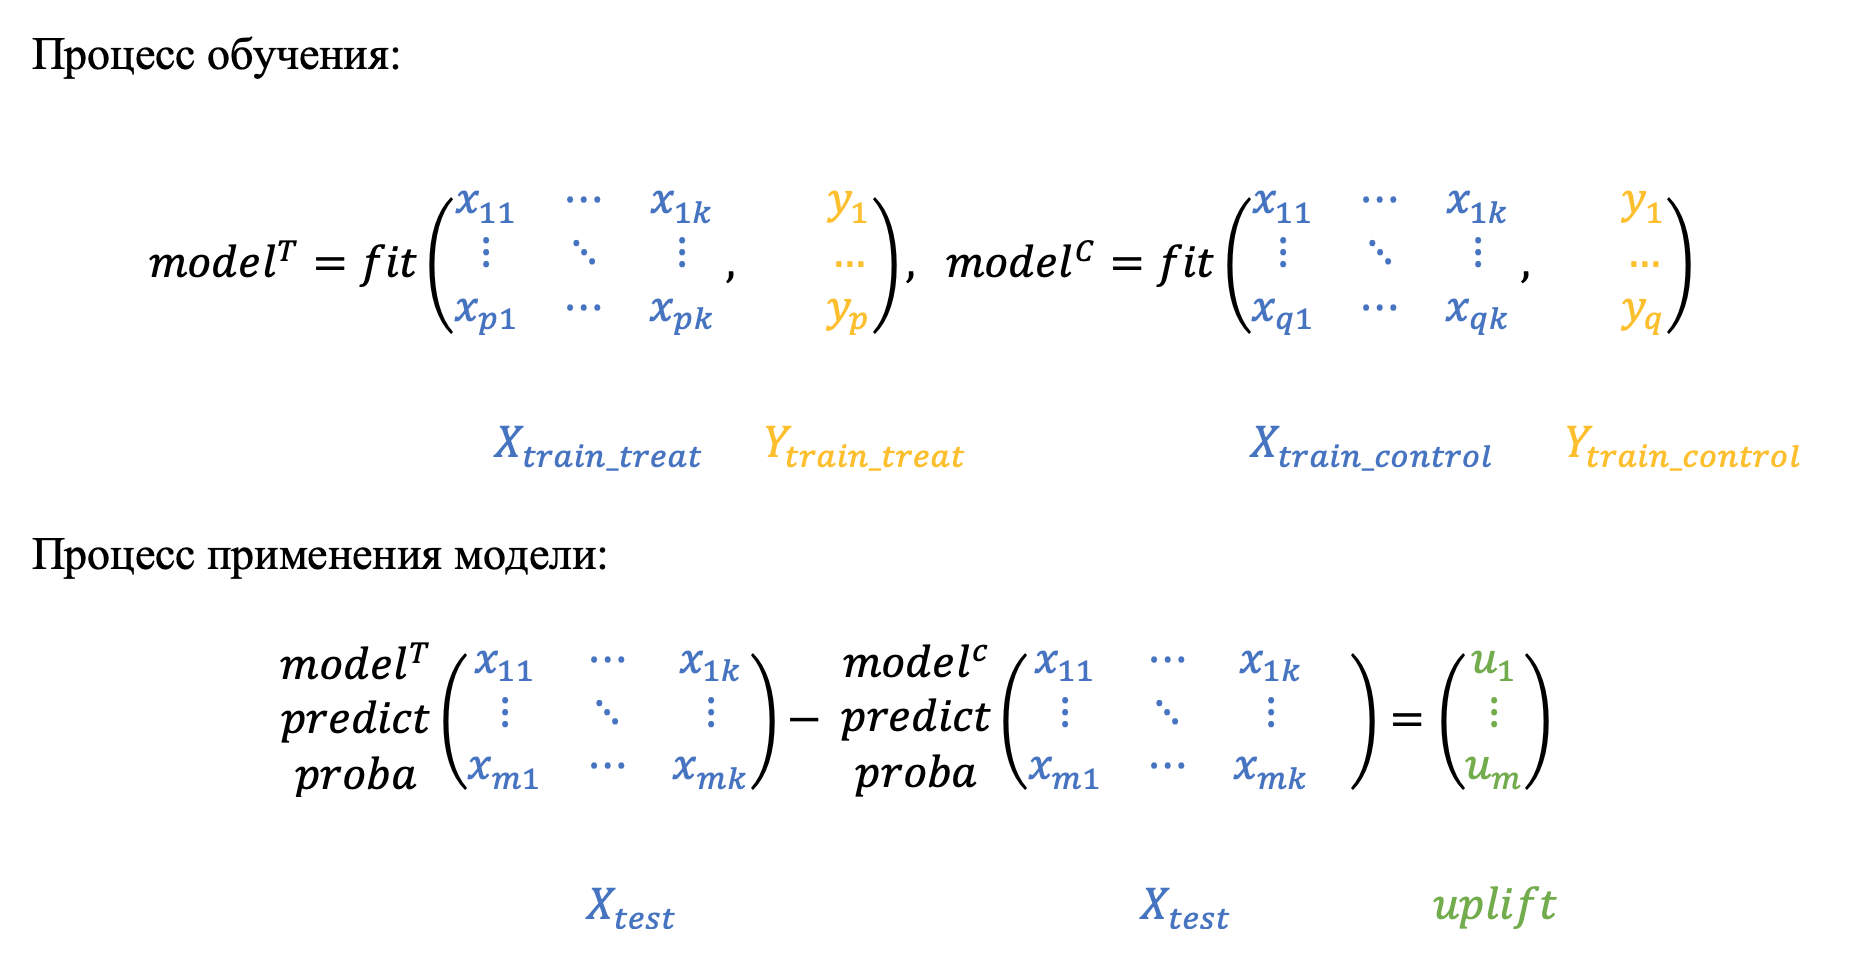


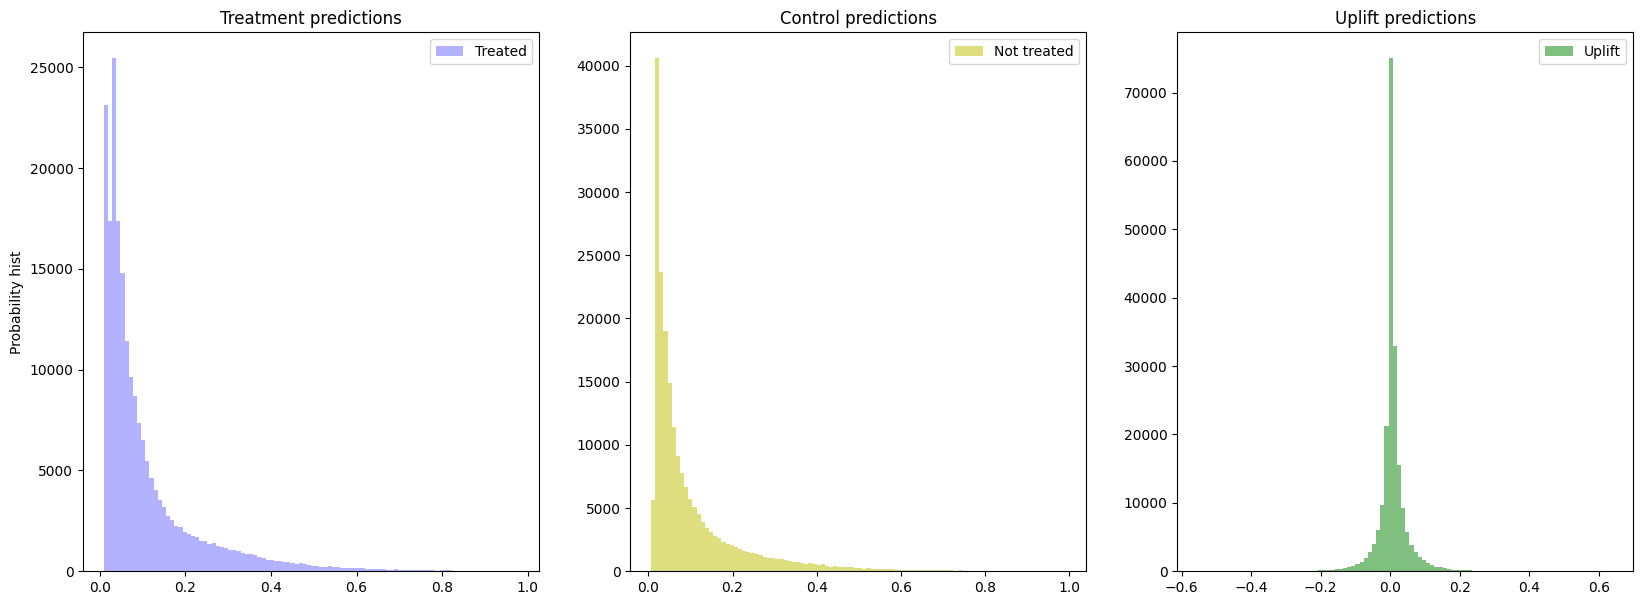

In [22]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True),
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True),
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, trmnt_train
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=trmnt_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [23]:
models_results

{'approach': ['pipe', 'SoloModel', 'ClassTransformation', 'TwoModels'],
 'uplift@30%': [0.03139659550634985,
  0.011857502164057954,
  0.03161840043430228,
  0.0097187352532431]}

### 2.2 Две зависимые модели

Подход зависимого представления данных основан на методе цепочек классификаторов, первоначально разработанном для задач многоклассовой классификации. Идея состоит в том, что при наличии $L$ различных меток можно построить $L$ различных классификаторов, каждый из которых решает задачу бинарной классификации и в процессе обучения каждый следующий классификатор использует предсказания предыдущих в качестве дополнительных признаков. Авторы данного метода предложили использовать ту же идею для решения проблемы uplift моделирования в два этапа. В начале мы обучаем классификатор по контрольным данным:
$$
P^C = P(Y=1| X, W = 0),
$$
затем исполним предсказания $P_C$ в качестве нового признака для обучения второго классификатора на тестовых данных, тем самым эффективно вводя зависимость между двумя наборами данных:

$$
P^T =  P(Y=1| X, P_C(X), W = 1)
$$

Чтобы получить uplift для каждого наблюдения, вычислим разницу:

$$
uplift(x_i) = P^T(x_i, P_C(x_i)) - P^C(x_i)
$$

Интуитивно второй классификатор изучает разницу между ожидаемым результатом в тесте и контроле, т.е. сам uplift.

<p align= "center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/TwoModels_ddr_control_RU.png" alt="Two dependent models"/>
</p>

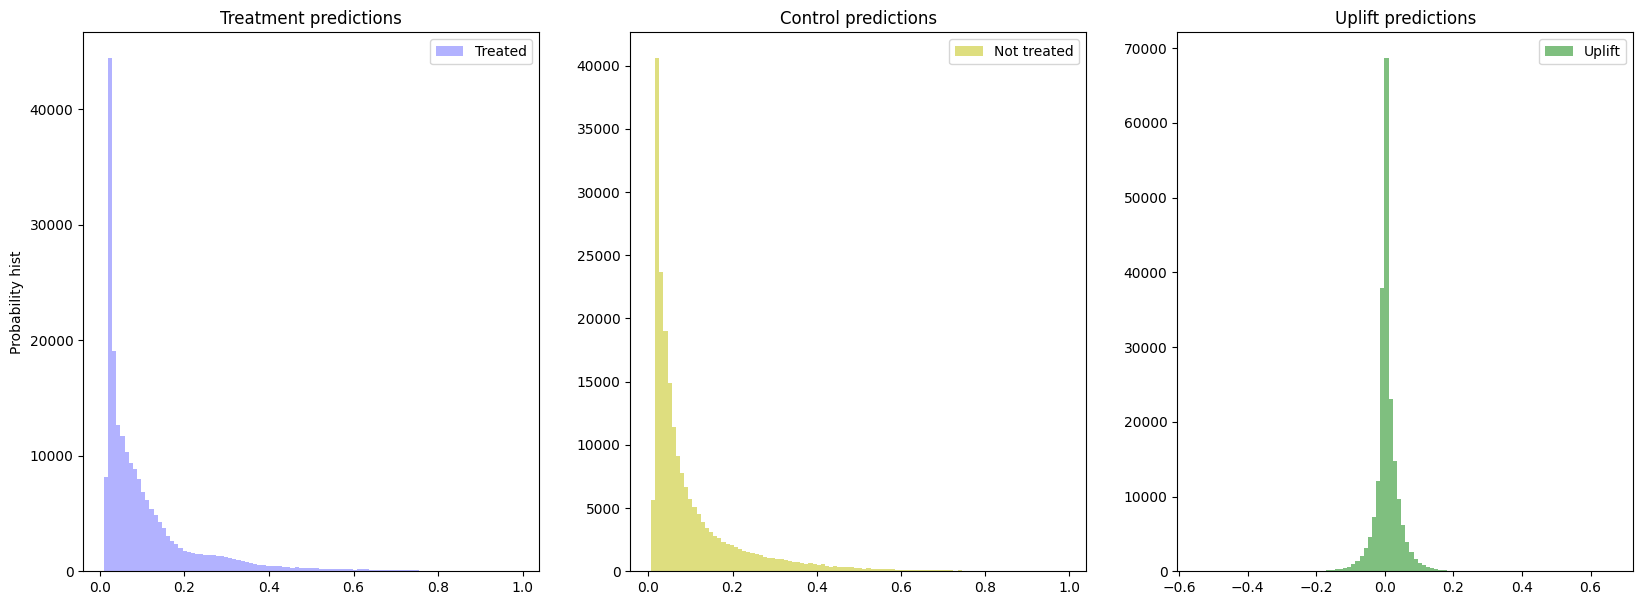

In [24]:
tm_ctrl = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True),
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True),
    method='ddr_control'
)
tm_ctrl = tm_ctrl.fit(
    X_train, y_train, trmnt_train
)

uplift_tm_ctrl = tm_ctrl.predict(X_val)

tm_ctrl_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_ctrl, treatment=trmnt_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_ddr_control')
models_results['uplift@30%'].append(tm_ctrl_score)

plot_uplift_preds(trmnt_preds=tm_ctrl.trmnt_preds_, ctrl_preds=tm_ctrl.ctrl_preds_);

Аналогичным образом можно сначала обучить классификатор $P^T$, а затем использовать его предсказания в качестве признака для классификатора $P^C$.

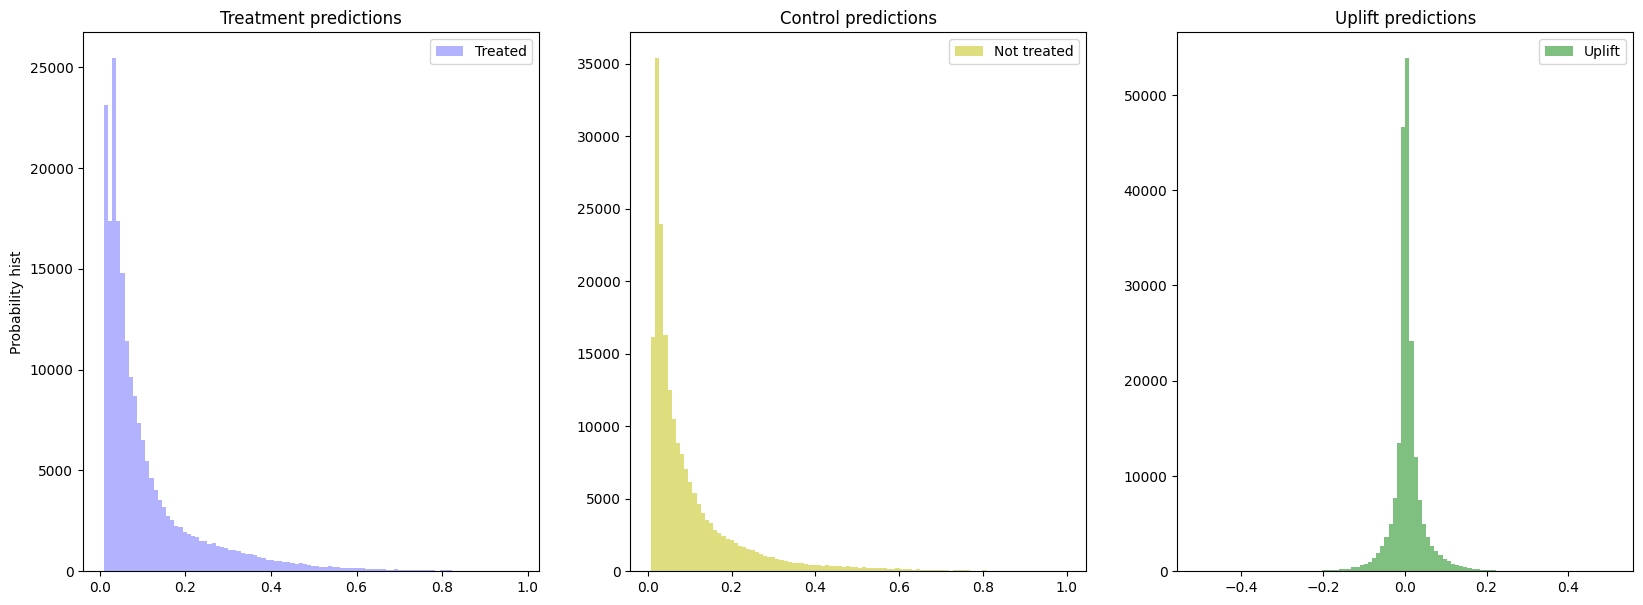

In [25]:
tm_trmnt = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True),
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True),
    method='ddr_treatment'
)
tm_trmnt = tm_trmnt.fit(
    X_train, y_train, trmnt_train
)

uplift_tm_trmnt = tm_trmnt.predict(X_val)

tm_trmnt_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_trmnt, treatment=trmnt_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_ddr_treatment')
models_results['uplift@30%'].append(tm_trmnt_score)

plot_uplift_preds(trmnt_preds=tm_trmnt.trmnt_preds_, ctrl_preds=tm_trmnt.ctrl_preds_);

## Заключение
Рассмотрим, какой метод лучше всего показал себя в этой задаче:

In [26]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
2,ClassTransformation,0.031618
0,pipe,0.031397
5,TwoModels_ddr_treatment,0.014210
4,TwoModels_ddr_control,0.013833
1,SoloModel,0.011858
3,TwoModels,0.009719


### Qini для победившей модели

In [27]:
from sklift.viz import plot_qini_curve

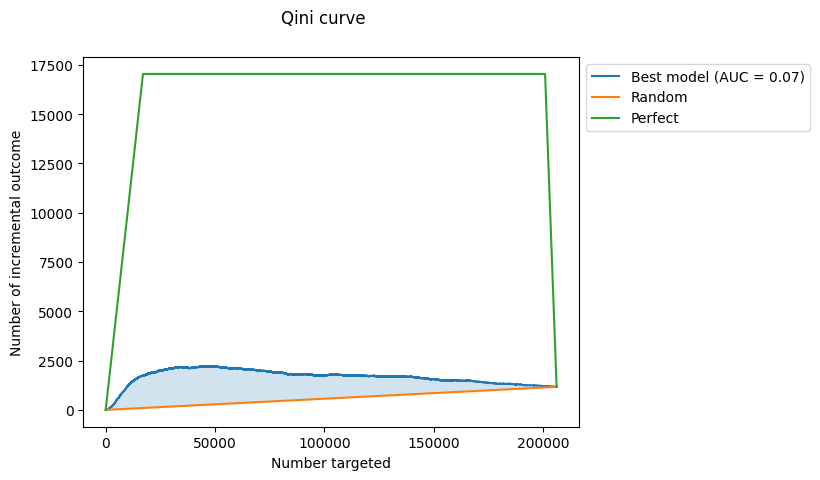

In [28]:
uplift_ct = ct.predict(X_val)
bets_disp = plot_qini_curve(y_val, uplift_ct, trmnt_val, perfect=True, name='Best model');
bets_disp.figure_.suptitle("Qini curve");

# 2. Positive-Unlabeled learning

развитие материалов [материалов](https://roywrightme.wordpress.com/2017/11/16/positive-unlabeled-learning/)

In [ ]:
## переделать на нормальный PL

In [87]:
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import precision_score, recall_score

In [88]:
class PL:
  def __init__(self, X, y, y_orig, steps = 20, num_iters = 20):
    self.X = X
    self.y = y
    self.count_1_orig = y[y['y'] == 1].count()
    self.rf = None
    self.results = pd.DataFrame({
      'truth'      : y_orig['y'],
      'label'      : y['y'],
    }, columns = ['truth', 'label'])
    self.stats = None
    self.steps = steps
    self.num_iters = num_iters

  def standard_classifier(self, n_estimators = 1000):
    self.rf = RandomForestClassifier(
      n_estimators = n_estimators,
      n_jobs = -1
    )
    self.rf.fit(self.X, self.y['y'])
    self.results['output_std'] = self.rf.predict_proba(self.X)[:,1]

  def two_step(self, n_estimators = 1000) -> pd.DataFrame:
    ys = 2 * self.y['y'] - 1
    # поменять местами

    # 1 for positive, -1 for unlabeled, and 0 for “reliable negative”
    # только где взять reliable negative ?
    # pred = self.rf.predict_proba(self.X)[:,1]
    #let’s find the range of scores given to the known positive data points:
    for k in tqdm(range(self.steps)):
      pred = self.rf.predict_proba(self.X)[:,1]
      range_P = [min(pred * (ys > 0)), max(pred * (ys > 0))]
      # Step 1: If any unlabeled point has a score below all known positives,
      # label it negative. On the other hand, if its score is above
      # all known positives, we might as well label it positive.

      qhigh = range_P[1] - (range_P[1] - range_P[0]) * k * 1 / self.steps
      qlow = range_P[0] #+ (range_P[1] - range_P[0]) * k * 1 / self.steps

      iP_new = ys[(ys < 0) & (pred >= qhigh)].index
      iN_new = ys[(ys < 0) & (pred <= qlow)].index
      ys.loc[iP_new] = 1
      ys.loc[iN_new] = 0
      rf2 = RandomForestClassifier(n_estimators = n_estimators, n_jobs = -1)
      for i in (range(self.num_iters)):
        # If step 1 didn't find new labels, we're done
        if len(iP_new) + len(iN_new) == 0 and i > 0:
            break
        print(
            'Step 1 labeled %d new positives and %d new negatives.'
            % (len(iP_new), len(iN_new))
        )
        print('Doing step 2... ', end = '')

        # Retrain on new labels and get new scores
        rf2.fit(self.X, ys)
        pred = rf2.predict_proba(self.X)[:,1] # -1

        # Find the range of scores given to positive data points
        range_P = [min(pred * (ys > 0)), max(pred * (ys > 0))]
        qhigh = range_P[1] - (range_P[1] - range_P[0]) * k * 1 / self.steps
        qlow = range_P[0] #+ (range_P[1] - range_P[0]) * k * 1 / self.steps

        # Repeat step 1
        iP_new = ys[(ys < 0) & (pred >= qhigh)].index
        iN_new = ys[(ys < 0) & (pred <= qlow)].index
        ys.loc[iP_new] = 1
        ys.loc[iN_new] = 0

      self.results[f'output_stp_{k}'] = ys
      self.results[f'output_stp_{k}'] = self.results[f'output_stp_{k}'].map(lambda x: 0 if x <=0 else 1)

  def calc_stats(self) -> pd.DataFrame:
    stats = []
    for k in range(self.steps):
      fp = self.results[(self.results['truth'] == 0) & (self.results[f'output_stp_{k}'] == 1)]['truth'].count()
      tp = self.results[(self.results['truth'] == 1) & (self.results[f'output_stp_{k}'] == 1)]['truth'].count()
      fn = self.results[(self.results['truth'] == 1) & (self.results[f'output_stp_{k}'] == 0)]['truth'].count()
      tn = self.results[(self.results['truth'] == 0) & (self.results[f'output_stp_{k}'] == 0)]['truth'].count()
      add_1 = fp + tp - int(self.count_1_orig)
      add_1_correct = tp - int(self.count_1_orig)
      recall = tp / (tp + fn)
      precision = tp / (tp + fp)

      stats.append([k
                    , add_1
                    , add_1_correct
                    , recall
                    , precision])
    self.stats = pd.DataFrame(stats, columns = ['k'
                                                , 'доп найденные единички'
                                                , 'доп верно найденные единички'
                                                , 'recall'
                                                , 'precision'])
    return self.stats

  def calc_all(self) -> pd.DataFrame:
    self.standard_classifier()
    self.two_step()
    return self.calc_stats()

In [89]:
np.random.seed(42)
n_features = 10
n_samples = 1000
df, y = make_classification(n_samples = n_samples, n_features =n_features, random_state = 42)
df = pd.DataFrame(df, columns = [f'feature_{k}' for k in range(n_features)])
df['y'] = y
cnt = df[df['y'] == 1]['y'].count()
print(f'исходное число единичек {cnt}')

# Unlabel a certain number of data points
hidden_size =  200

def unlabel(df, hidden_size):
  # Keep the original targets safe for later
  df_orig = df.copy()

  df.loc[
      np.random.choice(
          df[df['y'] == 1].index,
          replace = False,
          size = hidden_size
      )
  , 'y'] = 0
  return df, df_orig

df, df_orig = unlabel(df, hidden_size)

исходное число единичек 499


In [90]:
pl_test = PL(df.drop('y', axis = 1), df[['y']], df_orig[['y']])
results = pl_test.calc_all()

  0%|          | 0/20 [00:00<?, ?it/s]

Step 1 labeled 0 new positives and 26 new negatives.
Doing step 2... Step 1 labeled 55 new positives and 245 new negatives.
Doing step 2... 

  5%|▌         | 1/20 [00:16<05:07, 16.16s/it]

Step 1 labeled 0 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 1 new positives and 0 new negatives.
Doing step 2... 

 10%|█         | 2/20 [00:24<03:32, 11.79s/it]

Step 1 labeled 0 new positives and 0 new negatives.
Doing step 2... 

 15%|█▌        | 3/20 [00:30<02:31,  8.94s/it]

Step 1 labeled 0 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 2 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 2 new positives and 0 new negatives.
Doing step 2... 

 20%|██        | 4/20 [00:51<03:42, 13.91s/it]

Step 1 labeled 0 new positives and 0 new negatives.
Doing step 2... 

 25%|██▌       | 5/20 [01:00<02:57, 11.80s/it]

Step 1 labeled 0 new positives and 0 new negatives.
Doing step 2... 

 30%|███       | 6/20 [01:08<02:27, 10.52s/it]

Step 1 labeled 0 new positives and 0 new negatives.
Doing step 2... 

 35%|███▌      | 7/20 [01:12<01:52,  8.68s/it]

Step 1 labeled 0 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 2 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 2 new positives and 0 new negatives.
Doing step 2... 

 40%|████      | 8/20 [01:26<02:03, 10.28s/it]

Step 1 labeled 0 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 2 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 5 new positives and 0 new negatives.
Doing step 2... 

 45%|████▌     | 9/20 [01:41<02:07, 11.60s/it]

Step 1 labeled 0 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 1 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 2 new positives and 0 new negatives.
Doing step 2... 

 50%|█████     | 10/20 [01:55<02:04, 12.42s/it]

Step 1 labeled 0 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 1 new positives and 0 new negatives.
Doing step 2... 

 55%|█████▌    | 11/20 [02:04<01:43, 11.47s/it]

Step 1 labeled 0 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 4 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 3 new positives and 0 new negatives.
Doing step 2... 

 60%|██████    | 12/20 [02:18<01:38, 12.30s/it]

Step 1 labeled 0 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 5 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 3 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 1 new positives and 0 new negatives.
Doing step 2... 

 65%|██████▌   | 13/20 [02:38<01:41, 14.52s/it]

Step 1 labeled 0 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 3 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 1 new negatives.
Doing step 2... 

 70%|███████   | 14/20 [02:52<01:26, 14.35s/it]

Step 1 labeled 0 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 10 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 2 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 3 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 2 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 4 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 2 new positives and 1 new negatives.
Doing step 2... Step 1 labeled 3 new positives and 0 new negatives.
Doing step 2... 

 75%|███████▌  | 15/20 [03:30<01:46, 21.34s/it]

Step 1 labeled 0 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 12 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 2 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 4 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 3 new positives and 0 new negatives.
Doing step 2... 

 80%|████████  | 16/20 [03:52<01:27, 21.81s/it]

Step 1 labeled 3 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 20 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 10 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 15 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 8 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 9 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 14 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 1 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 4 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 1 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 3 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 1 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 5 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 3 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 3 new positives and 0 new neg

 85%|████████▌ | 17/20 [05:18<02:02, 41.00s/it]

Step 1 labeled 1 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 10 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 15 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 11 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 6 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 6 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 5 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 3 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 4 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 1 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 3 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 5 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 3 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 1 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 4 new positives and 0 new nega

 90%|█████████ | 18/20 [06:45<01:49, 54.79s/it]

Step 1 labeled 0 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 22 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 12 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 10 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 13 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 4 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 6 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 2 new positives and 0 new negatives.
Doing step 2... 

 95%|█████████▌| 19/20 [07:20<00:48, 48.98s/it]

Step 1 labeled 0 new positives and 0 new negatives.
Doing step 2... Step 1 labeled 14 new positives and 0 new negatives.
Doing step 2... 

100%|██████████| 20/20 [07:29<00:00, 22.47s/it]


In [91]:
results

,k,доп найденные единички,доп верно найденные единички,recall,precision
0,0,55,0,0.599198,0.844633
1,1,56,0,0.599198,0.842254
2,2,56,0,0.599198,0.842254
3,3,60,1,0.601202,0.835655
4,4,60,1,0.601202,0.835655
5,5,60,1,0.601202,0.835655
6,6,60,1,0.601202,0.835655
7,7,64,4,0.607214,0.834711
8,8,71,6,0.611222,0.824324
9,9,74,8,0.615230,0.823056


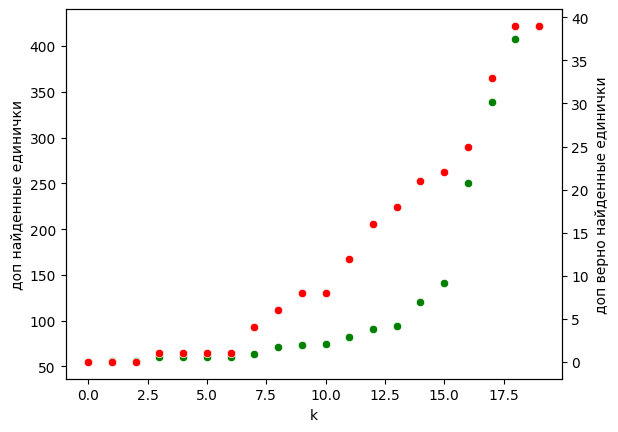

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
sns.scatterplot(x = results['k'], y = results['доп найденные единички'], ax = ax, color = 'g')
ax2 = ax.twinx()
sns.scatterplot(x = results['k'], y = results['доп верно найденные единички'], ax = ax2, color = 'r')
plt.show()

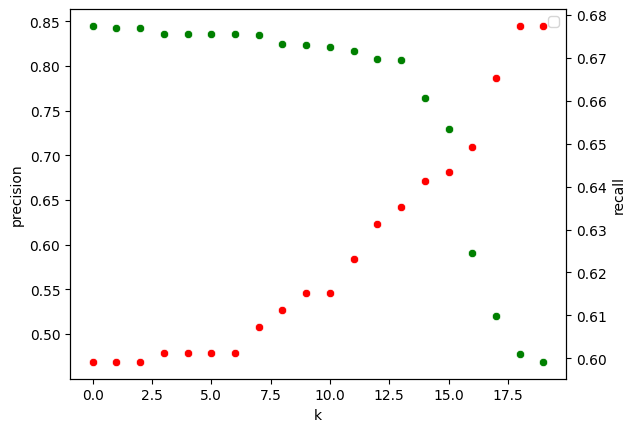

In [93]:
fig, ax = plt.subplots()
sns.scatterplot(x = results['k'], y = results['precision'], ax = ax, color = 'g')
ax2 = ax.twinx()
sns.scatterplot(x = results['k'], y = results['recall'], ax = ax2, color = 'r')
ax.legend()
plt.show()

# 3. Pseudolabelling здорового человека

In [129]:
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

In [154]:
np.random.seed(42)
n_features = 10
n_samples = 1000
df, y = make_classification(n_samples = n_samples, n_features =n_features, random_state = 42)
df = pd.DataFrame(df, columns = [f'feature_{k}' for k in range(n_features)])
df['y'] = y
cnt = df[df['y'] == 1]['y'].count()
print(f'исходное число единичек {cnt}')

# Unlabel a certain number of data points
hidden_size =  200

def unlabel(df, hidden_size):
  # Keep the original targets safe for later
  df_orig = df.copy()

  df.loc[
      np.random.choice(
          df[df['y'] == 1].index,
          replace = False,
          size = hidden_size
      )
  , 'y'] = 0
  return df, df_orig

df, df_orig = unlabel(df, hidden_size)
print('после сокрытия единичек', df[df['y'] == 1]['y'].count())
df['truth'] = df_orig['y']

исходное число единичек 499
после сокрытия единичек 299


In [155]:
count_zeros = df[df['y'] == 0]['y'].count()
rate = 0.3
df['is_train'] = 0
train_index = df[df['y'] == 1].copy().append(df[df['y'] == 0].sample(int(count_zeros * rate))).index
df.loc[df.index.isin(train_index), 'is_train'] = 1
df[df['is_train'] == 1].shape

(509, 13)

In [156]:
print(recall_score(df['truth'], df['y']), precision_score(df['truth'], df['y']))

0.5991983967935872 1.0


In [157]:
rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
rf.fit(df[df['is_train'] == 1].drop(['y', 'truth', 'is_train'], axis = 1), df[df['is_train'] == 1]['y'])
preds = rf.predict_proba(df.drop(['y', 'truth', 'is_train'], axis = 1))[:, 1]
df['rf1_preds'] = preds

In [163]:
save = df.copy()
res = []
for tr in [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.22, 0.25, 0.3, 0.35, 0.4]:
  df.loc[(df['is_train'] == 0) & (df['rf1_preds'] <= tr), 'y'] = 0
  df.loc[(df['is_train'] == 0) & (df['rf1_preds'] > 1 - tr), 'y'] = 1
  df.loc[(df['is_train'] == 0) & ((df['rf1_preds'] <= tr)| (df['rf1_preds'] > 1 - tr) ), 'is_train'] = 1
  rf2 = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
  rf2.fit(df[df['is_train'] == 1].drop(['y', 'truth', 'is_train', 'rf1_preds'], axis = 1), df[df['is_train'] == 1]['y'])
  preds2 = rf2.predict_proba(df.drop(['y', 'truth', 'is_train', 'rf1_preds'], axis = 1))[:, 1]
  df['rf2_preds'] = preds2
  df.loc[(df['is_train'] == 0) & (df['rf2_preds'] <= tr), 'y'] = 0
  df.loc[(df['is_train'] == 0) & (df['rf2_preds'] > 1 - tr), 'y'] = 1
  rec = recall_score(df['truth'], df['y'])
  prc = precision_score(df['truth'], df['y'])
  print(tr, rec)
  df = save.copy()
  res.append([tr, rec, prc])
res = pd.DataFrame(res, columns = ['tr', 'rec', 'prc'])

0.05 0.6132264529058116
0.06 0.6172344689378757
0.07 0.6332665330661322
0.08 0.625250501002004
0.09 0.6392785571142284
0.1 0.6513026052104208
0.15 0.6913827655310621
0.2 0.7314629258517034
0.22 0.7555110220440882
0.25 0.7735470941883767
0.3 0.7975951903807615
0.35 0.8216432865731463
0.4 0.8336673346693386


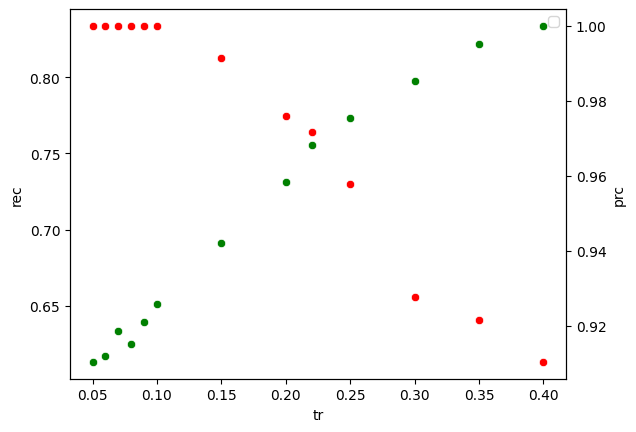

In [164]:
fig, ax = plt.subplots()
sns.scatterplot(x = res['tr'], y = res['rec'], ax = ax, color = 'g')
ax2 = ax.twinx()
sns.scatterplot(x = res['tr'], y = res['prc'], ax = ax2, color = 'r')
plt.show()

In [152]:
tr = 0.9
df.loc[(df['is_train'] == 0) & (df['rf1_preds'] <= tr), 'y'] = 0
df.loc[(df['is_train'] == 0) & (df['rf1_preds'] > 1 - tr), 'y'] = 1
df.loc[(df['is_train'] == 0) & ((df['rf1_preds'] <= tr)| (df['rf1_preds'] > 1 - tr) ), 'is_train'] = 1
rf2 = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
rf2.fit(df[df['is_train'] == 1].drop(['y', 'truth', 'is_train', 'rf1_preds'], axis = 1), df[df['is_train'] == 1]['y'])
preds2 = rf2.predict_proba(df.drop(['y', 'truth', 'is_train', 'rf1_preds'], axis = 1))[:, 1]
df['rf2_preds'] = preds2
df.loc[(df['is_train'] == 0) & (df['rf2_preds'] <= tr), 'y'] = 0
df.loc[(df['is_train'] == 0) & (df['rf2_preds'] > 1 - tr), 'y'] = 1
recall_score(df['truth'], df['y'])

0.6212424849699398

In [165]:
save = df.copy()
df.loc[(df['is_train'] == 0) & (df['rf1_preds'] <= tr), 'y'] = 0
df.loc[(df['is_train'] == 0) & (df['rf1_preds'] > 1 - tr), 'y'] = 1
df.loc[(df['is_train'] == 0) & ((df['rf1_preds'] <= tr)| (df['rf1_preds'] > 1 - tr) ), 'is_train'] = 1
rf2 = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
rf2.fit(df[df['is_train'] == 1].drop(['y', 'truth', 'is_train', 'rf1_preds'], axis = 1), df[df['is_train'] == 1]['y'])
preds2 = rf2.predict_proba(df.drop(['y', 'truth', 'is_train', 'rf1_preds'], axis = 1))[:, 1]
df['rf2_preds'] = preds2
df.loc[(df['is_train'] == 0) & (df['rf2_preds'] <= tr), 'y'] = 0
df.loc[(df['is_train'] == 0) & (df['rf2_preds'] > 1 - tr), 'y'] = 1

In [172]:
recovered = hidden_size - df[(df['truth'] == 1) & (df['y'] == 0)]['y'].count()
print(f'восстановили {recovered} единичек')
fp = df[(df['truth'] == 0) & (df['y'] == 1)]['y'].count()
print(f'false positive {fp} -- сколько ноликов назвали единичками')
positive_rate_start = (len(df['y']) - count_zeros) / len(df['y'])
print(f'вероятность получать единички если сэмплировать случайно {positive_rate_start}')

восстановили 116 единичек
false positive 43 -- сколько ноликов назвали единичками
вероятность получать единички если сэмплировать случайно 0.299
